<a href="https://colab.research.google.com/github/FranMoritz/Projetos/blob/main/C%C3%B3pia_de_C%C3%B3pia_de_C%C3%B3pia_de_C%C3%B3pia_de_An%C3%A1lise_da_Jornada_de_Abertura_de_Conta_Digital_%E2%80%93_Funil%2C_Atrito_e_Testes_A_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise da Jornada de Abertura de Conta Digital em Banco – Funil, Atrito e Testes A/B**


---


***Problema: O Head de CX tem o desafio de aumentar o número de novas contas em 20% e precisa de um dashboard para visualizar de forma direta e clara onde os clientes estão desistindo, quais os atrititos e pequenas mudanças podem salvar milhões.***


Objetivo do notebook:

Entender o funil de abertura de conta digital.

Medir atrito por etapa.

Analisar comportamento por segmentos.

Avaliar impacto de testes A/B.

Simulação financeira de impacto.

Gerar bases refinadas para um dashboard executivo.

# **Árvore lógica do problema**


---

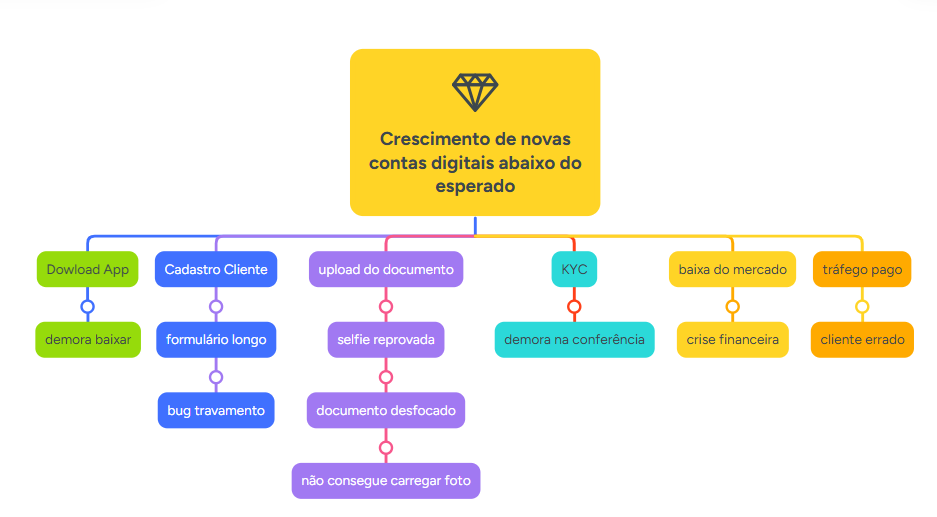

Aqui é construído junto a equipe, levantamos as hipóteses pricipais e seus respectivos problemas

In [ ]:
#acessando o drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#importando as libs usadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#chamando a tabela eventos
df_events = pd.read_csv("/content/gdrive/My Drive/banco/journey_events.csv",
                            delimiter=',',
                            encoding= 'utf-8'#'latin1' 'utf-8' 'latin1'
                            )

In [ ]:
#chamando a tabela summary
df_summary = pd.read_csv("/content/gdrive/My Drive/banco/journey_summary.csv",
                            delimiter=',',
                            encoding= 'utf-8'#'latin1' 'utf-8' 'latin1'
                            )

In [ ]:
df_events.shape

(18690, 19)

In [ ]:
df_summary.shape

(5000, 18)

# **Dicionário**

# **Tabela 1 – journey_events**

Cada linha representa um evento em uma etapa da jornada de abertura de conta.


---



| Coluna                | Tipo          | Descrição                                                                         | Exemplo                                |
| --------------------- | ------------- | --------------------------------------------------------------------------------- | -------------------------------------- |
| `journey_id`          | string (UUID) | Identificador único da jornada (uma tentativa de abertura de conta).              | `9f3e2c98-9a8b-4c1a-9e1d-19c0f7b1a21b` |
| `customer_id`         | int           | Identificador do cliente (pode aparecer em mais de uma jornada).                  | `58234`                                |
| `event_timestamp`     | datetime      | Data e hora em que o evento na etapa ocorreu.                                     | `2025-01-12 14:23:10`                  |
| `step_name`           | string        | Nome da etapa da jornada.                                                         | `doc_upload`                           |
| `step_order`          | int           | Ordem da etapa no funil (1 = início, 7 = final).                                  | `3`                                    |
| `step_status`         | string        | Status do evento na etapa: `started`, `completed` ou `abandoned`.                 | `completed`                            |
| `abandonment_reason`  | string        | Motivo do abandono quando `step_status = 'abandoned'`. Vazio caso contrário.      | `doc_blurry`                           |
| `device_type`         | string        | Tipo de dispositivo usado na jornada.                                             | `android`, `ios`, `web`                |
| `os_version`          | string        | Versão do sistema operacional do dispositivo.                                     | `android_13`, `ios_17`                 |
| `channel_acquisition` | string        | Canal de aquisição do usuário.                                                    | `paid_ads`, `organic`, `referral`      |
| `network_type`        | string        | Tipo de conexão de rede utilizada.                                                | `wifi`, `4g`, `5g`                     |
| `region`              | string        | Região geográfica simulada do cliente.                                            | `sudeste`, `sul`                       |
| `segment_income_band` | string        | Faixa de renda simulada do cliente.                                               | `baixa`, `media`, `alta`               |
| `risk_score_band`     | string        | Faixa de risco (ex.: crédito / antifraude) atribuída ao cliente.                  | `baixo`, `medio`, `alto`               |
| `experiment_name`     | string        | Nome do experimento A/B aplicado à jornada (quando aplicável).                    | `doc_upload_ui_v1`, `form_reduced_v2`  |
| `variant`             | string        | Variante do experimento A/B que o cliente recebeu.                                | `A`, `B`                               |
| `is_approved`         | int (0/1)     | Indica se a jornada resultou em conta aprovada naquele evento (1 = sim, 0 = não). | `0`                                    |
| `kyc_result`          | string        | Resultado da etapa de validação KYC (quando `step_name = 'kyc_validation'`).      | `approved`, `denied`, `manual_review`  |
| `session_id`          | string (UUID) | Identificador da sessão do usuário durante a jornada.                             | `c1f47c9e-5c79-49f7-8f7e-9e09e2dbf5c0` |


# **Tabela 2 – journey_summary**

Cada linha representa um resumo de uma jornada (uma tentativa de abertura de conta, concluída ou abandonada).


---



| Coluna                | Tipo          | Descrição                                                                                          | Exemplo                                      |
| --------------------- | ------------- | -------------------------------------------------------------------------------------------------- | -------------------------------------------- |
| `journey_id`          | string (UUID) | Identificador único da jornada (chave primária).                                                   | `9f3e2c98-9a8b-4c1a-9e1d-19c0f7b1a21b`       |
| `customer_id`         | int           | Identificador do cliente associado à jornada.                                                      | `58234`                                      |
| `journey_start_ts`    | datetime      | Data e hora do primeiro evento da jornada.                                                         | `2025-01-12 14:22:05`                        |
| `journey_end_ts`      | datetime      | Data e hora do último evento da jornada.                                                           | `2025-01-12 14:26:40`                        |
| `final_step_order`    | int           | Ordem da última etapa alcançada na jornada.                                                        | `7`                                          |
| `final_step_reached`  | string        | Nome da última etapa alcançada na jornada (pode ser abandono ou conclusão).                        | `account_approved` ou `kyc_validation`       |
| `device_type`         | string        | Tipo de dispositivo predominante na jornada (herdado da tabela de eventos).                        | `android`                                    |
| `channel_acquisition` | string        | Canal de aquisição do usuário (herdado da tabela de eventos).                                      | `paid_ads`                                   |
| `region`              | string        | Região geográfica do cliente.                                                                      | `sudeste`                                    |
| `segment_income_band` | string        | Faixa de renda do cliente.                                                                         | `media`                                      |
| `risk_score_band`     | string        | Faixa de risco do cliente.                                                                         | `medio`                                      |
| `experiment_name`     | string        | Nome do experimento A/B ligado à jornada (quando aplicável).                                       | `doc_upload_ui_v1`                           |
| `variant`             | string        | Variante do experimento recebida (`A` ou `B`).                                                     | `B`                                          |
| `approved_flag`       | int (0/1)     | Indica se a jornada resultou em conta aprovada (1) ou não (0).                                     | `1`                                          |
| `total_duration_sec`  | float         | Duração total da jornada em segundos (`journey_end_ts - journey_start_ts`).                        | `275.0`                                      |
| `cac`                 | float         | Custo de aquisição estimado por canal para essa jornada.                                           | `18.0` para `paid_ads`, `5.0` para `organic` |
| `expected_revenue_1y` | float         | Receita projetada em 1 ano para essa jornada (R$ 420,00 quando aprovada; 0 quando não aprovada).   | `420.0`                                      |
| `lost_revenue_1y`     | float         | Receita potencial perdida em 1 ano quando a jornada não é aprovada

(R$ 420,00; 0 quando aprovada). | `0.0` ou `420.0`                             |


In [ ]:
df_events.head()

,journey_id,customer_id,event_timestamp,step_name,step_order,step_status,abandonment_reason,device_type,os_version,channel_acquisition,network_type,region,segment_income_band,risk_score_band,experiment_name,variant,is_approved,kyc_result,session_id
0,0c692978-8385-4d1b-b56d-7281922453f7,93810,2025-01-27 20:58:00,app_download,1,completed,NaN,android,android_12,referral,wifi,sul,baixa,alto,doc_upload_ui_v1,A,0,NaN,4c8ea545-c26d-4d5c-99b3-4005b7807dd4
1,0c692978-8385-4d1b-b56d-7281922453f7,93810,2025-01-27 20:58:35,onboarding_start,2,abandoned,doc_blurry,android,android_12,referral,wifi,sul,baixa,alto,doc_upload_ui_v1,A,0,NaN,4c8ea545-c26d-4d5c-99b3-4005b7807dd4
2,117d4a8e-548f-4926-990d-3f02f9661e6e,88907,2025-01-20 05:36:00,app_download,1,completed,NaN,android,android_13,partner,wifi,nordeste,alta,medio,doc_upload_ui_v1,A,0,NaN,c3dd0ddb-4daf-4f55-8c8c-11167fe9e7d2
3,117d4a8e-548f-4926-990d-3f02f9661e6e,88907,2025-01-20 05:37:39,onboarding_start,2,abandoned,selfie_denied,android,android_13,partner,wifi,nordeste,alta,medio,doc_upload_ui_v1,A,0,NaN,c3dd0ddb-4daf-4f55-8c8c-11167fe9e7d2
4,e41610a0-10fa-43b8-a3af-7f4ba1b960cd,22156,2025-01-18 05:27:00,app_download,1,abandoned,selfie_denied,ios,android_12,referral,4g,norte,media,baixo,form_reduced_v2,A,0,NaN,46b773ab-830d-4e06-8f87-2261027c34b9


In [ ]:
df_summary.head()

,journey_id,customer_id,journey_start_ts,journey_end_ts,final_step_order,final_step_reached,device_type,channel_acquisition,region,segment_income_band,risk_score_band,experiment_name,variant,approved_flag,total_duration_sec,cac,expected_revenue_1y,lost_revenue_1y
0,00045d84-03fb-46dd-9719-74649c942055,12115,2025-01-11 14:25:00,2025-01-11 14:25:00,1,app_download,ios,partner,nordeste,baixa,alto,form_reduced_v2,A,0,0.0,12.0,0.0,420.0
1,0009a6d7-df2b-435c-a7a0-da97aa55cbdb,85493,2025-01-11 04:10:00,2025-01-11 04:12:48,2,onboarding_start,web,referral,nordeste,alta,alto,form_reduced_v2,A,0,168.0,8.0,0.0,420.0
2,0009bd99-a3c5-4bc2-81c3-400dc161ec96,71440,2025-01-07 08:08:00,2025-01-07 08:11:51,4,selfie_biometric,android,organic,norte,alta,medio,form_reduced_v2,A,0,231.0,5.0,0.0,420.0
3,000eaaef-31d0-4884-b693-90bf2b434548,71302,2025-01-30 21:08:00,2025-01-30 21:08:00,1,app_download,android,paid_ads,norte,media,alto,doc_upload_ui_v1,A,0,0.0,18.0,0.0,420.0
4,00300d02-7504-4561-b713-f85bbd3da0df,43263,2025-01-08 08:43:00,2025-01-08 08:43:00,1,app_download,ios,partner,sul,alta,baixo,doc_upload_ui_v1,B,0,0.0,12.0,0.0,420.0


# **Entendendo o funil de abertura de conta**



As etapas são:

Dowload do aplicativo;

Preenchimento formulário;

Upload dos documentos;

Selfie e biometria;

KYC - validação das informações;

Assinatura de contrato;

Aprovação da conta;



In [ ]:
#etapas distintas e ordem
df_events[['step_name', 'step_order']].drop_duplicates().sort_values('step_order')


,step_name,step_order
0,app_download,1
1,onboarding_start,2
9,doc_upload,3
10,selfie_biometric,4
11,kyc_validation,5
12,contract_sign,6
13,account_approved,7


In [ ]:
#Quantos journey existem em ambas as tabelas
df_events['journey_id'].nunique(), df_summary.shape


(5000, (5000, 18))

In [ ]:
#distribuição da jornada aprovadas x não aprovada
df_summary['approved_flag'].value_counts(normalize=True)*100


,proportion
approved_flag,
0,74.84
1,25.16


a proporção de contas aprovadas é de apenas 25% contra 74% não aprovadas, isso pode indicar algum problema acontecendo nas etapas cruciais da jornada.

# **Métricas de Funil e Atrito por Etapa**

Construindo o funil e métricas de abandono por etapa

In [ ]:
# Journeys por etapa - quantos journeys passam por cada etapa
funnel_counts = (
    df_events[df_events['step_status'] != 'abandoned']  # considera quem pelo menos chegou na etapa
    .groupby('step_name')['journey_id']
    .nunique()
    .reset_index(name='journeys_at_step')
)

# Ordenar pela ordem do funil
step_order_map = df_events.set_index('step_name')['step_order'].to_dict()
funnel_counts['step_order'] = funnel_counts['step_name'].map(step_order_map)
funnel_counts = funnel_counts.sort_values('step_order')

funnel_counts


,step_name,journeys_at_step,step_order
1,app_download,3996,1
5,onboarding_start,2973,2
3,doc_upload,2485,3
6,selfie_biometric,1601,4
4,kyc_validation,1377,5
2,contract_sign,1258,6
0,account_approved,1258,7


Aqui podemos ver que conforme as etapas vão avançando a taxa de desistência aumenta.

In [ ]:
#conversão para próxima etapa e receita perdida por etapa
funnel_counts['journeys_next_step'] = funnel_counts['journeys_at_step'].shift(-1)
funnel_counts['step_dropoff_rate'] = 1 - (funnel_counts['journeys_next_step'] / funnel_counts['journeys_at_step'])


# Junta info de última etapa com revenue perdido
loss_by_final_step = (
    df_summary
    .groupby('final_step_reached')['lost_revenue_1y']
    .sum()
    .reset_index(name='lost_revenue_1y')
)

funnel_final = funnel_counts.merge(loss_by_final_step, left_on='step_name', right_on='final_step_reached', how='left')
funnel_final


,step_name,journeys_at_step,step_order,journeys_next_step,step_dropoff_rate,final_step_reached,lost_revenue_1y
0,app_download,3996,1,2973.0,0.256006,app_download,421680.0
1,onboarding_start,2973,2,2485.0,0.164144,onboarding_start,429660.0
2,doc_upload,2485,3,1601.0,0.355734,doc_upload,204960.0
3,selfie_biometric,1601,4,1377.0,0.139913,selfie_biometric,371280.0
4,kyc_validation,1377,5,1258.0,0.086420,kyc_validation,94080.0
5,contract_sign,1258,6,1258.0,0.000000,contract_sign,49980.0
6,account_approved,1258,7,NaN,NaN,account_approved,0.0


Cerca de 25% das pessoas que fazem o dowload do app deixam de preencher o formulário de cadastro.

Cerca de 35% das pessoas não finalizam a validação da selfie.

# **Segmentação da Jornada (renda, risco, canal, device)**

Segmentação: quem sofre mais no funil?

In [ ]:
#Taxa de aprovação por faixa de renda
approval_by_income = (
    df_summary
    .groupby('segment_income_band')['approved_flag']
    .mean()
    .reset_index(name='approval_rate')
    .sort_values('approval_rate', ascending=False)
)
approval_by_income




,segment_income_band,approval_rate
0,alta,0.264117
1,baixa,0.251640
2,media,0.239260


a classe média tem a menor taxa de aprovação

In [ ]:
#Abandono por canal de aquisição
approval_by_channel = (
    df_summary
    .groupby('channel_acquisition')['approved_flag']
    .mean()
    .reset_index(name='approval_rate')
)
approval_by_channel


,channel_acquisition,approval_rate
0,organic,0.263878
1,paid_ads,0.248804
2,partner,0.252541
3,referral,0.241013


referral = referência tem a menor taxa de aprovação



In [ ]:
#Cruzar por device_type
approval_by_device = (
    df_summary
    .groupby('device_type')['approved_flag']
    .mean()
    .reset_index(name='approval_rate')
)
approval_by_device


,device_type,approval_rate
0,android,0.243567
1,ios,0.265913
2,web,0.245146


Aparelhos celulares com android e via web tem as menores taxas de aprovação, pode ser por conta do hardware.

# **Análise de Testes A/B**

Os testes consistem em:

1-Formulário de dados atual x formulário em forma de diálogo;

2-Instrução para selfie atual x instruções mais claras para selfie;

In [ ]:
#chamando a tabela do teste
df_testeab = pd.read_csv("/content/gdrive/My Drive/banco/ab_custom_tests.csv",
                            delimiter=',',
                            encoding= 'utf-8'#'latin1' 'utf-8' 'latin1'
                            )

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

def calcular_pvalue_ab(df):
    resultados = []

    for exp in df["experiment_name"].unique():
        temp = df[df["experiment_name"] == exp]

        # Separa variantes
        A = temp.iloc[0]
        B = temp.iloc[1]

        # Conversões absolutas (aprovados)
        conv_A = int(A["approval_rate"] * A["journeys"])
        conv_B = int(B["approval_rate"] * B["journeys"])

        # Tamanhos
        n_A = int(A["journeys"])
        n_B = int(B["journeys"])

        # Vetores do teste
        counts = np.array([conv_A, conv_B])
        nobs = np.array([n_A, n_B])

        # Teste Z
        stat, pvalue = proportions_ztest(counts, nobs)

        # Uplift
        uplift = (A["approval_rate"], B["approval_rate"],
                  B["approval_rate"] - A["approval_rate"])

        resultados.append({
            "experiment_name": exp,
            "variant_A": A["variant"],
            "variant_B": B["variant"],
            "approval_A": A["approval_rate"],
            "approval_B": B["approval_rate"],
            "uplift_B_minus_A": uplift[2],
            "z_statistic": stat,
            "p_value": pvalue
        })

    return pd.DataFrame(resultados)


# ---- executar ----
resultado_estatistico = calcular_pvalue_ab(df_testeab)
resultado_estatistico


,experiment_name,variant_A,variant_B,approval_A,approval_B,uplift_B_minus_A,z_statistic,p_value
0,onboarding_start,form_old,form_dialog,0.24,0.31,0.07,-3.789559,0.000151
1,selfie_biometric,selfie_old,selfie_guide,0.27,0.36,0.09,-4.516477,0.000006


<Figure size 1000x500 with 0 Axes>

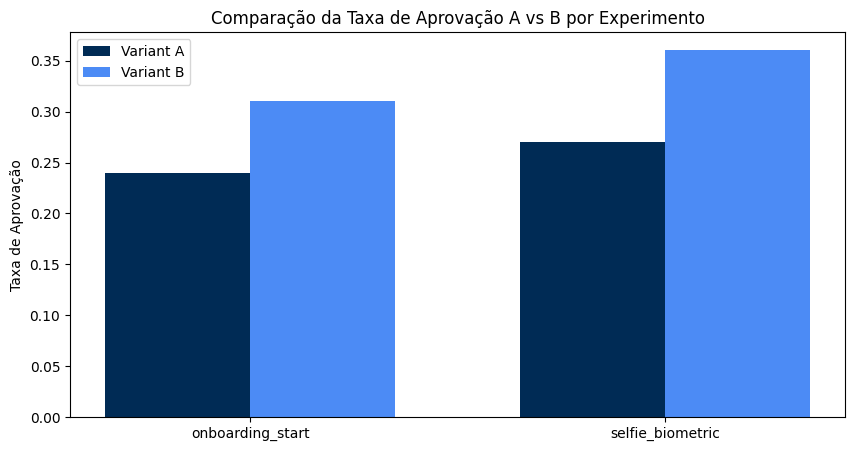

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# dataframe resultado_estatistico já deve estar criado

plt.figure(figsize=(10, 5))

experimentos = resultado_estatistico["experiment_name"]
approval_A = resultado_estatistico["approval_A"]
approval_B = resultado_estatistico["approval_B"]

x = np.arange(len(experimentos))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - width/2, approval_A, width, label='Variant A', color='#002B55')
ax.bar(x + width/2, approval_B, width, label='Variant B', color='#4C8BF5')

ax.set_ylabel('Taxa de Aprovação')
ax.set_title('Comparação da Taxa de Aprovação A vs B por Experimento')
ax.set_xticks(x)
ax.set_xticklabels(experimentos, rotation=0)
ax.legend()

plt.show()


onboarding_start ----> A variante em formato de diálogo melhora a conversão em +7 pontos percentuais.

selfie_biometric ----> A variante em formato de diálogo melhora a conversão em +9 pontos percentuais.

Os dois experimentos A/B apresentaram melhorias estatisticamente significativas na conversão do funil.

No onboarding, o formulário em formato de diálogo aumentou a aprovação em 7 pontos percentuais (p < 0,001), sugerindo maior clareza e engajamento.

Na etapa de selfie biométrica, a introdução de instruções claras gerou impacto ainda maior: +9 pontos percentuais (p < 0,001).

Ambos experimentos devem ser priorizados para rollout, pois geram ganhos de conversão altamente confiáveis e com impacto financeiro direto.



# **Simulação de retorno financeiro com a implementação das variantes de melhora**

In [ ]:
import pandas as pd

# df_testeab deve ter as colunas:
# ['experiment_name', 'variant', 'journeys', 'approval_rate', 'avg_revenue']

def simular_impacto_financeiro(df_testeab, periodos_por_ano=12):
    resultados = []

    for exp, sub in df_testeab.groupby("experiment_name"):
        # Ordena pela receita média para definir baseline (pior) e vencedor (melhor)
        sub_sorted = sub.sort_values("avg_revenue")

        baseline = sub_sorted.iloc[0]   # Variante com menor receita média
        winner  = sub_sorted.iloc[-1]  # Variante com maior receita média

        # Volume total de jornadas usado na simulação (mantém o volume atual)
        total_journeys = sub["journeys"].sum()

        # Receita média por jornada (old vs new)
        baseline_avg_rev = baseline["avg_revenue"]
        winner_avg_rev   = winner["avg_revenue"]

        # Cenário 1 – se 100% das jornadas usassem a variante baseline
        revenue_baseline = total_journeys * baseline_avg_rev

        # Cenário 2 – se 100% das jornadas usassem a variante vencedora
        revenue_winner = total_journeys * winner_avg_rev

        # Impacto (no período observado)
        delta_abs = revenue_winner - revenue_baseline
        delta_pct = delta_abs / revenue_baseline if revenue_baseline > 0 else None

        # Extrapolação anual (assumindo que o período é mensal)
        revenue_baseline_ano = revenue_baseline * periodos_por_ano
        revenue_winner_ano   = revenue_winner * periodos_por_ano
        delta_abs_ano        = delta_abs * periodos_por_ano

        resultados.append({
            "experiment_name": exp,
            "baseline_variant": baseline["variant"],
            "winner_variant": winner["variant"],
            "total_journeys_sim": int(total_journeys),

            "baseline_avg_revenue": round(baseline_avg_rev, 2),
            "winner_avg_revenue": round(winner_avg_rev, 2),

            "revenue_if_baseline_periodo": round(revenue_baseline, 2),
            "revenue_if_winner_periodo": round(revenue_winner, 2),
            "delta_revenue_periodo": round(delta_abs, 2),
            "delta_pct_periodo": round(delta_pct * 100, 2) if delta_pct is not None else None,

            "revenue_if_baseline_ano": round(revenue_baseline_ano, 2),
            "revenue_if_winner_ano": round(revenue_winner_ano, 2),
            "delta_revenue_ano": round(delta_abs_ano, 2),
        })

    return pd.DataFrame(resultados)


# ---- executar a simulação ----
impacto_financeiro = simular_impacto_financeiro(df_testeab, periodos_por_ano=12)
impacto_financeiro


,experiment_name,baseline_variant,winner_variant,total_journeys_sim,baseline_avg_revenue,winner_avg_revenue,revenue_if_baseline_periodo,revenue_if_winner_periodo,delta_revenue_periodo,delta_pct_periodo,revenue_if_baseline_ano,revenue_if_winner_ano,delta_revenue_ano
0,onboarding_start,form_old,form_dialog,2380,100,130,238000,309400,71400,30.0,2856000,3712800,856800
1,selfie_biometric,selfie_old,selfie_guide,2190,105,145,229950,317550,87600,38.1,2759400,3810600,1051200


“Se adotarmos o formulário em formato de diálogo e as instruções de selfie, o banco pode aumentar a receita em aproximadamente 30% e 38% ao mês.”

# **Exportando bases refinadas para o dashboard**

In [ ]:
# Funil com atrito e perda financeira por etapa
funnel_final.to_csv("/content/gdrive/My Drive/banco/funnel_final.csv", index=False)

# Segmentação
approval_by_income.to_csv("/content/gdrive/My Drive/banco/seg_income_dashboard.csv", index=False)
approval_by_channel.to_csv("/content/gdrive/My Drive/banco/seg_channel_dashboard.csv", index=False)
approval_by_device.to_csv("/content/gdrive/My Drive/banco/seg_device_dashboard.csv", index=False)

# A/B e impacto financeiro
resultado_estatistico.to_csv("/content/gdrive/My Drive/banco/resultado_estatistico.csv", index=False)
impacto_financeiro.to_csv("/content/gdrive/My Drive/banco/impacto_financeiro.csv", index=False)


# **Conclusão**


---


Principais gargalos do funil: Preenchimento dos dados e selfie.

Segmentos que mais sofrem: Pesoas da classe média, dispositivos android e via web, que chegam até nós via tráfego de referência.

Experimentos que trazem mais ganho: Mudar o formúlário tradicional para  formato conversa e instruções mais claras sobre como tirar selfie.

Estimativa financeira da melhoria: Expectativa de melhora na receita de 30% e 38%, aumentando a aprovação em 7 pontos para formulário e 9 pontos para selfie.



**“Os dados mostram que concentrar esforços nas etapas preenchimento dos dados e selfie, principalmente para clientes do segmento da classe média, celulares com android e via web e que venham do tráfego orgânico, pode gerar um aumento estimado de R$1.908.000 na receita anual, ao combinar otimização de fluxo e rollout da melhor variante dos testes A/B.”**